In [9]:
import pandas as pd

In [11]:
df = pd.read_csv('./creditcard.csv')

In [12]:
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [57]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Separata data into X/y
y = df['Class'].values
X = df.drop(['Class', 'Time'], axis=1).values

num_neg = (y==0).sum()
num_pos = (y==1).sum()

# Scaling..
scaler = RobustScaler()
X = scaler.fit_transform(X)

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Class
0    284315
1       492
dtype: int64


<Axes: xlabel='Class', ylabel='count'>

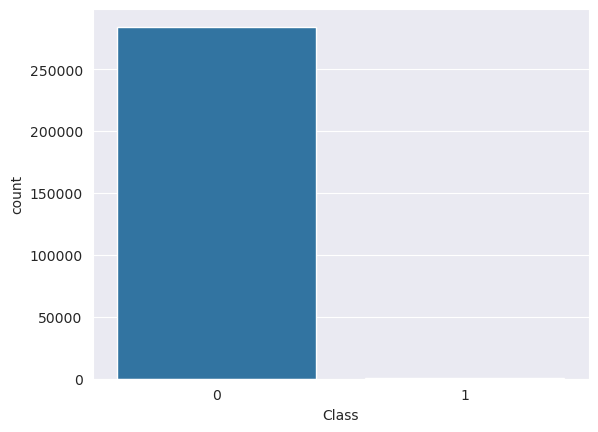

In [60]:
import seaborn as sns

print(df.groupby('Class').size())

sns.countplot(x="Class", data=df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.85      0.61      0.71        90

    accuracy                           1.00     56962
   macro avg       0.92      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962



(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

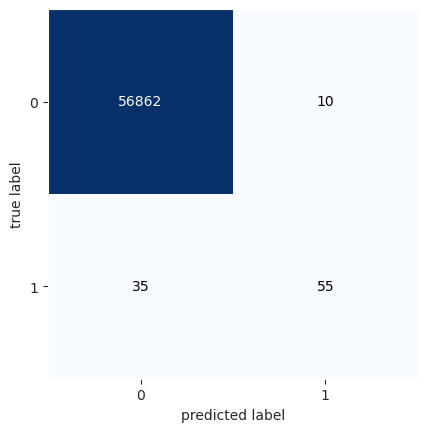

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt

lr = LogisticRegression()

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

One possibility is to tell the logistic regression there is class-imbalance and to put weights on errors proportional to the class imbalance. 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56872
           1       0.06      0.89      0.11        90

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962



(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

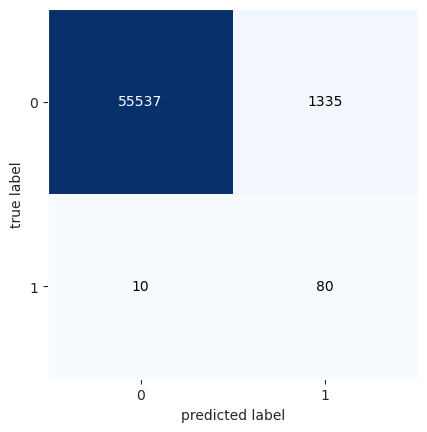

In [63]:
lr = LogisticRegression(class_weight='balanced')

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

We can also tune the class weights manually to find a better trade-off between false positives, false negatives and detected fraud cases. 

Best parameters : {'class_weight': {0: 0.14473684210526316, 1: 0.8552631578947368}}


<Axes: xlabel='weight'>

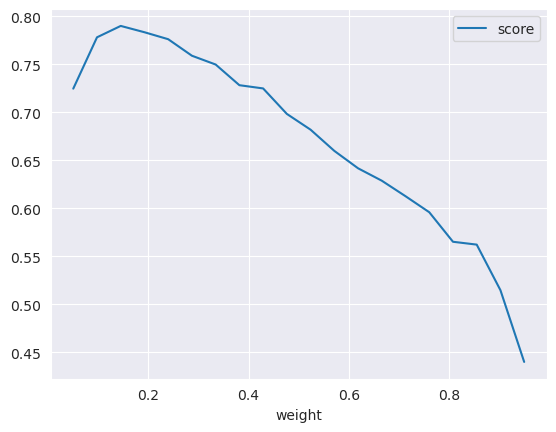

In [64]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)
import numpy as np
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

Now we create a logistic regression with the optimum parameters we discovered above and plot results again. This version reseults in a more balanced tradeoff between false positives, false negatives and finding fraud cases.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.79      0.83      0.81        90

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

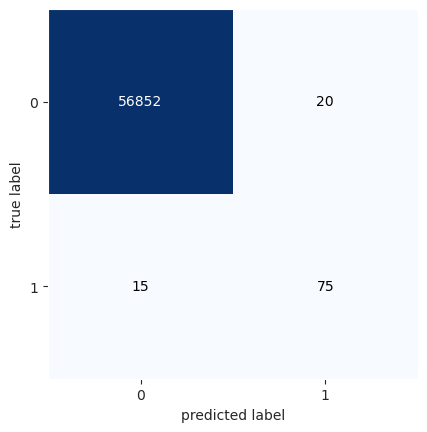

In [65]:
lr = LogisticRegression(**grid_result.best_params_)

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))